In [1]:
#imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [18]:
NUM_ROUNDS = 10

plt.rcParams["figure.figsize"] = (12, 50) #(12,50)

#load in the image, collapse it from a 3d array to a 1d array of 3d points, finally convert the data to 32-bit integers
img = cv.imread('images/road_downscaled_smollestest.jpg')
Z = img.reshape((-1, 3))
Z = np.float32(Z)
# Z = np.int32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

90
62


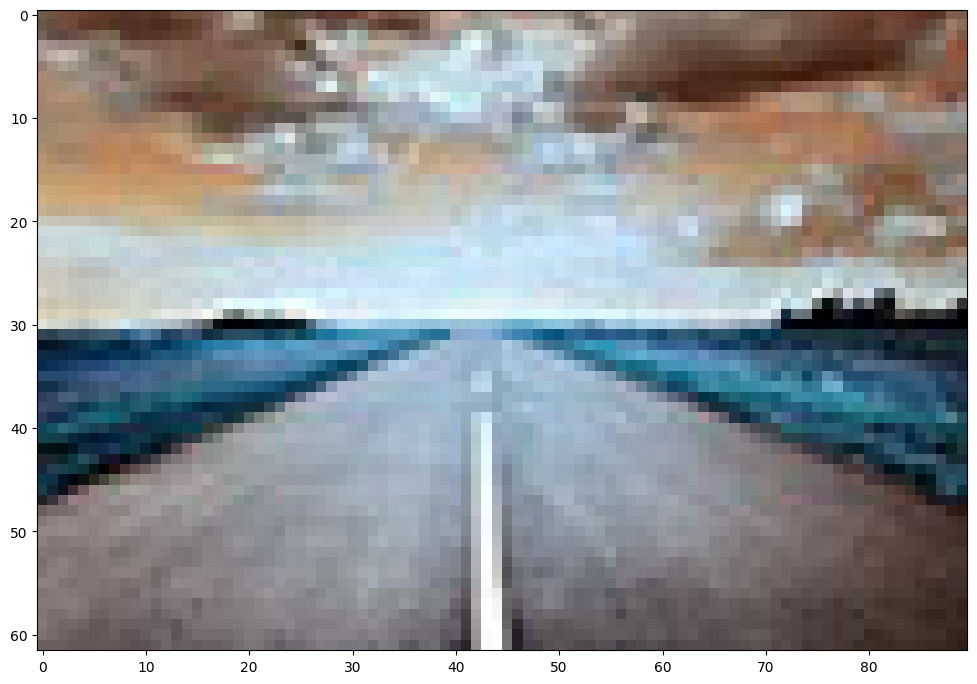

In [3]:
print(len(img[0])) #width
print(len(img)) #height

plt.imshow(img)

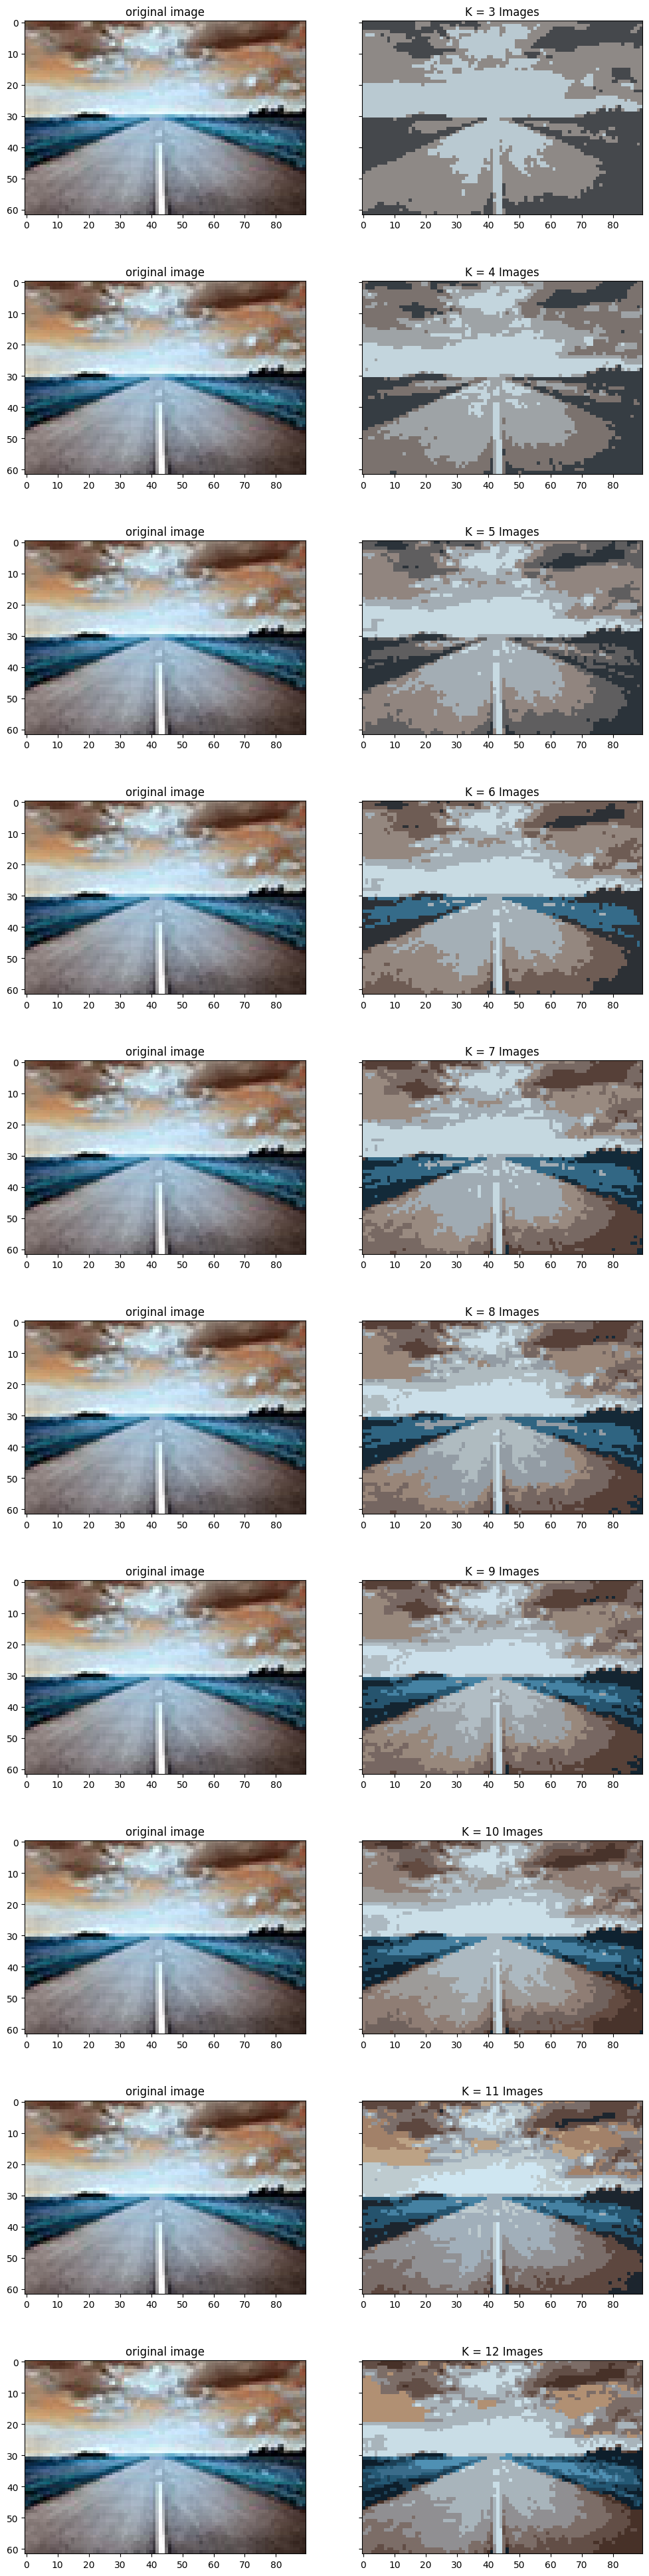

In [19]:
fig, ax = plt.subplots(NUM_ROUNDS, 2, sharey=True)
for i in range(NUM_ROUNDS):
    K = i+3

    ret, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    ax[i, 1].imshow(res2)
    ax[i, 1].set_title('K = %s Images' %K)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title('original image')

In [5]:
#pyspark import huppeldepup
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets as D
from scipy.spatial import distance_matrix

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [6]:
class UndirectedWeightedGraph:
    def __init__(self, edge_weights, vertices):
        self.__edge_weights = edge_weights
        self.__vertices = vertices
        
    def vertices(self):
        return self.__vertices
        
    def weight(self, v1, v2):
        if v1 < v2 and v1 in self.__edge_weights and v2 in self.__edge_weights[v1]:
            return self.__edge_weights[v1][v2]
        elif v2 < v1 and v2 in self.__edge_weights and v1 in self.__edge_weights[v2]:
            return self.__edge_weights[v2][v1]
        else:
            return math.inf

    def induced_graph(self, vertices):
        self.__vertices = vertices
        # TODO: filter edges for cleanliness

In [7]:
# create an edge dictionary
# note that this dictionary is triangle shaped, so be careful when acessing!
edges = {}
for i in range(len(Z)):
    edges_vertex = {}
    for j in range(i+1, len(Z)):
        # calculate the p2 norm but without taking the square root: computationally less expensive
        edges_vertex[j] = (Z[i][0] - Z[j][0])**2 + (Z[i][1] - Z[j][1])**2 + (Z[i][2] - Z[j][2])**2
    edges[i] = edges_vertex

In [8]:
graph = UndirectedWeightedGraph(edges, [i for i in range(len(Z))])

In [9]:
graph.weight(2, 5)

np.float32(738.0)

# Pyspark

In [10]:
spark = (SparkSession
    .builder
    .appName("Affinity Clustering")
    .getOrCreate())

In [11]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Affinity Clustering>

In [12]:
# TODO: work around this hardcoded graph reference without copying the graph n-times
def find_best_neighbor_map(vertex):
    return (vertex, min(graph.vertices(), key=lambda v: graph.weight(vertex, v)))

def find_best_neighbor_mpc(graph):
    findbestneighbors_input = graph.vertices()

    best_neighbors = (sc.parallelize(findbestneighbors_input)
        .map(lambda x: find_best_neighbor_map(x))
        .collect())
    
    best_neighbor_m = {}
    for vertex, neighbor in best_neighbors:
        best_neighbor_m[vertex] = neighbor
        
    return best_neighbor_m

In [13]:
def find_leader_map(vertex, best_neighbor):
    c = vertex
    v = vertex
    S = []

    while v not in S:
        S.append(v)
        c = min(c, v)
        v = best_neighbor[v]

    return (vertex, c)

def find_leader_mpc(graph, best_neighbor):
    find_leader_input = graph.vertices()
    
    leaders = (sc.parallelize(find_leader_input)
        .map(lambda x: find_leader_map(x, best_neighbor))
        .collect())
    
    leader_m = {}
    for vertex, leader in leaders:
        leader_m[vertex] = leader
    
    return leader_m

In [14]:
# This is currently unused: because our graph is a complete graph, the contraction step
# boils down to just taking the induced graph of the leaders

def contraction_mpc_map(vertex, best_neighbor):
    c = vertex
    v = vertex
    S = []
    
    while v not in S:
        S.append(v)
        c = min(c, v)
        v = best_neighbor_m[v]
    
    return (c, neighbourhood)

def contraction_mpc_reduce(x, best_neighbor_m, leader_m):
    c, neighborhoods = x
    
    neighborhood = [ v for n in neighborhoods for v in n ]
    
    # reroute edges to leaders
    neighborhood = [ (leader_m[v], w) for v, w in neighborhood ]
    # remove edges pointing to c
    neighborhood = [ (v, w) for v, w in neighborhood if v != c ]
    # choose edges with smallest weight
    neighbor_weights = {}
    for v, w in neighborhood:
        if not v in neighbor_weights:
            neighbor_weights[v] = [w]
        else:
            neighbor_weights[v].append(w)
    neighborhood = []
    for n in neighbor_weights:
        neighborhood.append((n, min(neighbor_weights[n])))
    
    return (c, neighborhood)

# TODO: see if it is possible to compute the induced subgraph in an mpc manner
def contraction_mpc(graph, best_neighbors, leaders):
    filteredvertices = list(dict.fromkeys(leaders.values()))
    
    graph = UndirectedWeightedGraph(edges, filteredvertices)

    return graph
    
    # return (sc.parallelize(contraction_input)
    #     .map(lambda x: contraction_mpc_map(x, best_neighbor_m)) #finds leader and assigns neighborhood of x
    #     .combineByKey(to_list, append, extend)
    #     .map(lambda x: contraction_mpc_reduce(x, best_neighbor_m, leader_m))
    #     .collect())

In [15]:
def affinity_clustering(graph, steps=1):
    result = []
    mapping = {}
    for v in graph.vertices():
        mapping[v] = v

    for step in range(steps):
        print('graph size before = %s' %len(graph.vertices()))

        print("finding neighbors")
        best_neighbors = find_best_neighbor_mpc(graph)
        print("finding leaders")
        leaders = find_leader_mpc(graph, best_neighbors)
        print("contracting graph")

        for v in mapping.keys():
            mapping[v] = leaders[mapping[v]]

        result.append(mapping.copy())

        # create the induced graph by removing non-leader vertices
        # note that we modify the current graph rather than creating a copy
        # this is for performance reasons
        filteredvertices = list(dict.fromkeys(leaders.values()))   
        graph.induced_graph(filteredvertices)
        
        print('graph size after = %s' %len(graph.vertices()))

    return result

In [16]:
result = affinity_clustering(graph, NUM_ROUNDS)

graph size before = 5580
finding neighbors
finding leaders
contracting graph
graph size after = 2259
graph size before = 2259
finding neighbors
finding leaders
contracting graph
graph size after = 1053
graph size before = 1053
finding neighbors
finding leaders
contracting graph
graph size after = 487
graph size before = 487
finding neighbors
finding leaders
contracting graph
graph size after = 248
graph size before = 248
finding neighbors
finding leaders
contracting graph
graph size after = 135
graph size before = 135
finding neighbors
finding leaders
contracting graph
graph size after = 72
graph size before = 72
finding neighbors
finding leaders
contracting graph
graph size after = 40
graph size before = 40
finding neighbors
finding leaders
contracting graph
graph size after = 19
graph size before = 19
finding neighbors
finding leaders
contracting graph
graph size after = 11
graph size before = 11
finding neighbors
finding leaders
contracting graph
graph size after = 4


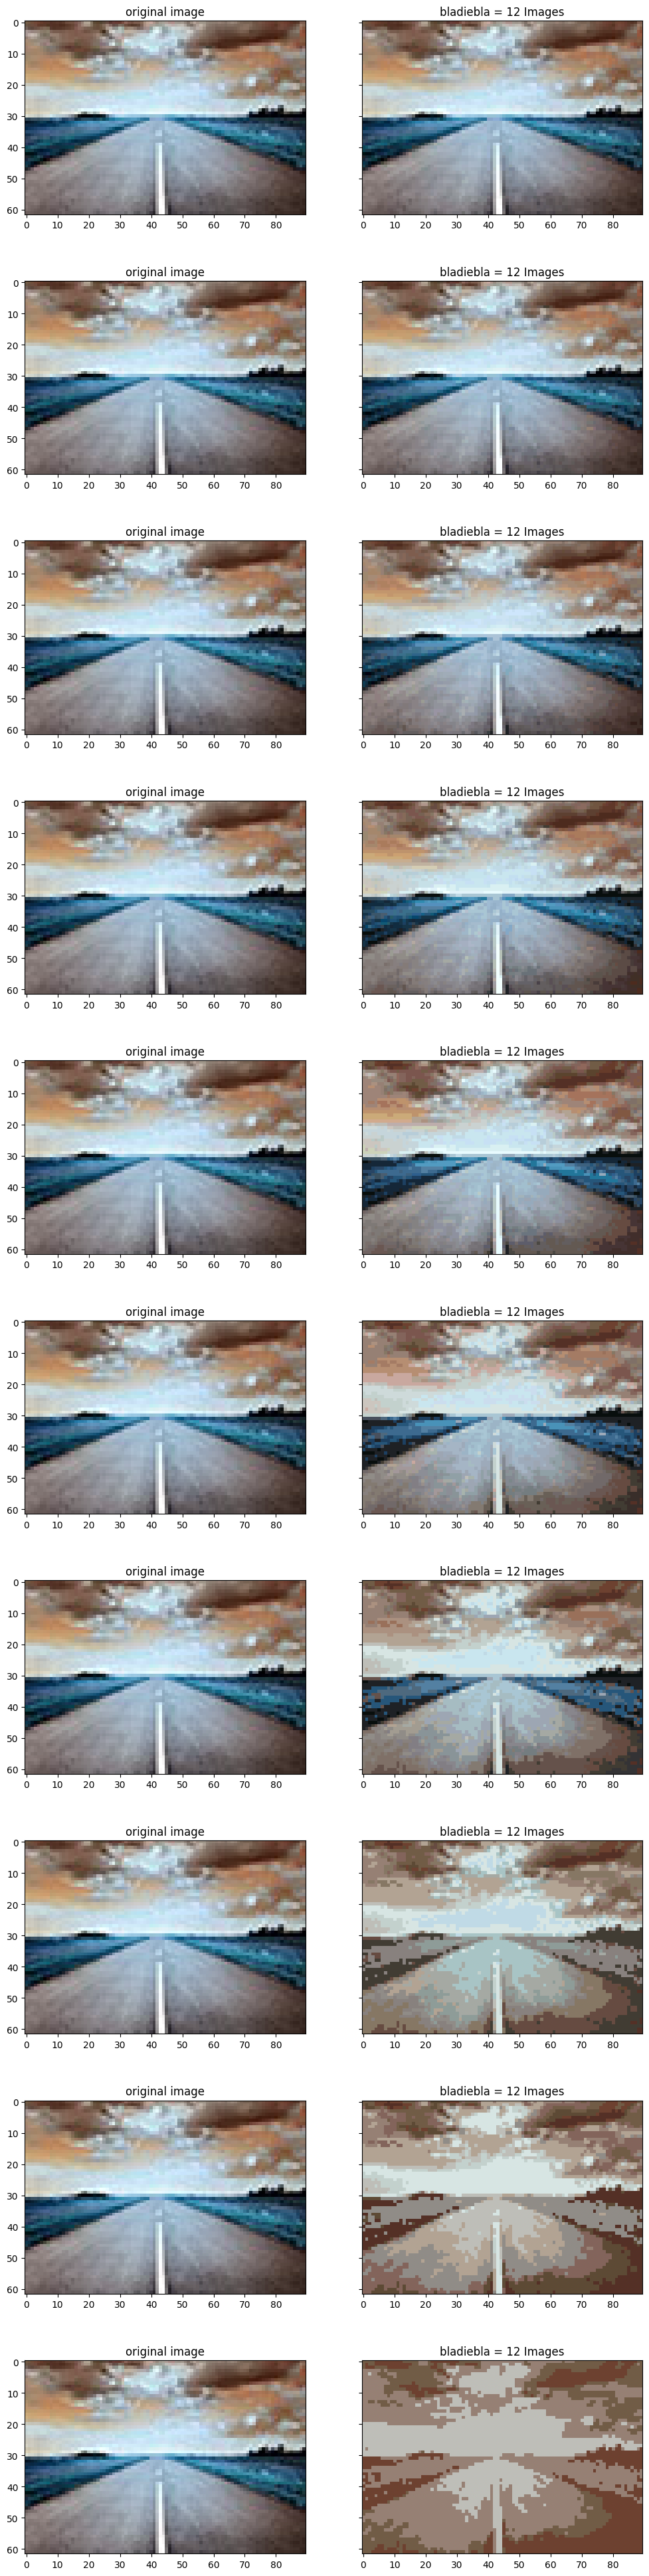

In [20]:
fig, ax = plt.subplots(NUM_ROUNDS, 2, sharey=True)

# result contains a mapping from a vertex to the leader it belongs to

#TODO: visualize
for i in range(len(result)):
    r = result[i]
    res = np.uint8([Z[l] for l in r.values()])
    res2 = res.reshape((img.shape))
    
    ax[i, 1].imshow(res2)
    ax[i, 1].set_title('bladiebla = %s Images' %len(dict.fromkeys()))
    ax[i, 0].imshow(img)
    ax[i, 0].set_title('original image')